In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [3]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
df[df == '?'] = np.nan

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [7]:
for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

C:\Users\mazlu\AppData\Local\Temp\ipykernel_21628\344784494.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [8]:
col_names = ['age', 'workclass', 'finalweight', 'education', 'education_num', 'marital_status', 'occupation', 'relationship',
             'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
df.columns = col_names

In [9]:
df['education'].unique()

array(['HS-grad', 'Some-college', '7th-8th', '10th', 'Doctorate',
       'Prof-school', 'Bachelors', 'Masters', '11th', 'Assoc-acdm',
       'Assoc-voc', '1st-4th', '5th-6th', '12th', '9th', 'Preschool'],
      dtype=object)

In [10]:
categorical = [col for col in df.columns if df[col].dtype == 'object']
numerical = [col for col in df.columns if df[col].dtype != 'object']

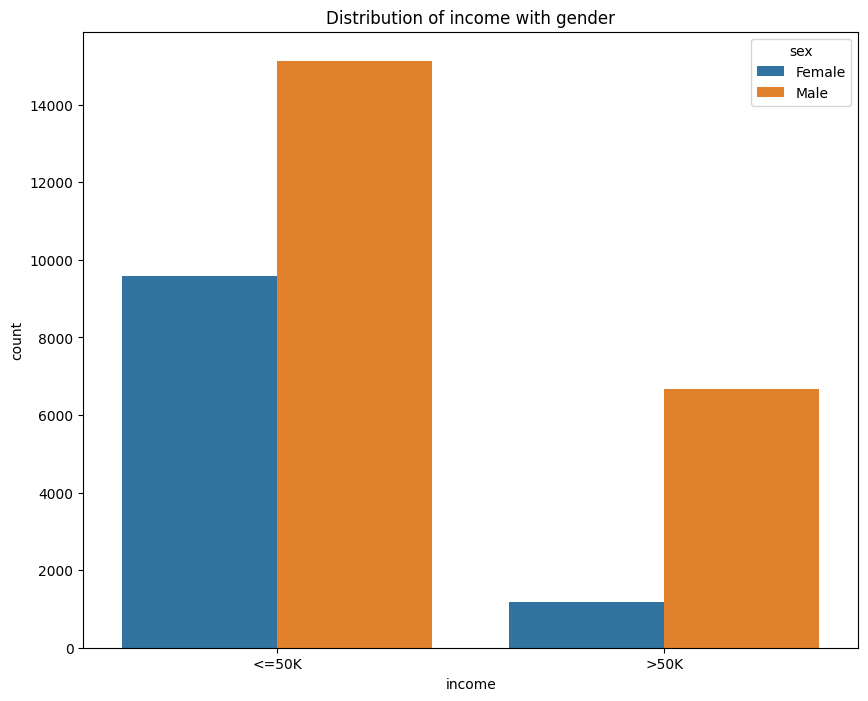

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.countplot(x="income", hue="sex", data=df)
ax.set_title("Distribution of income with gender")
plt.show()

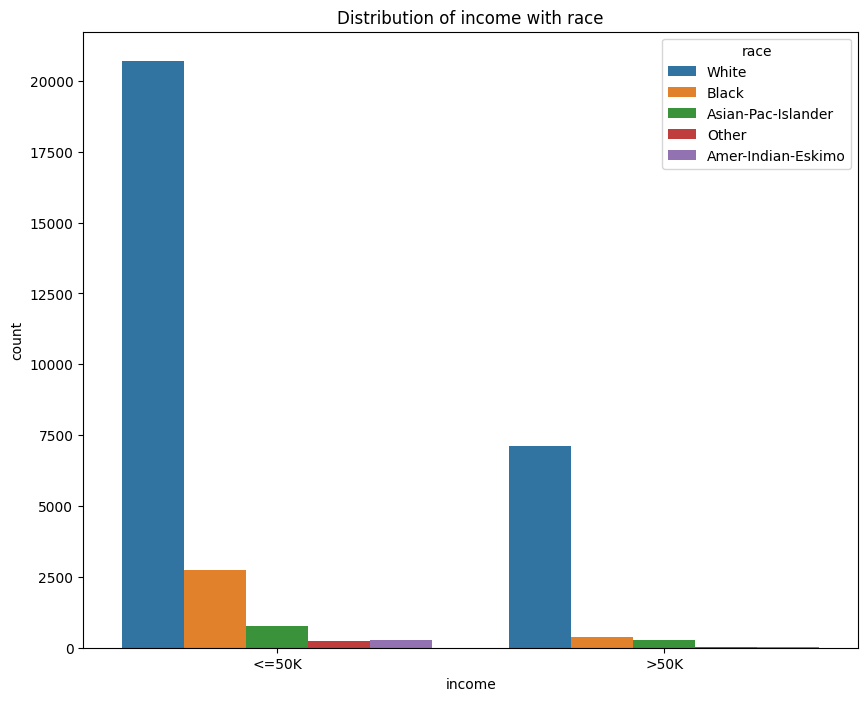

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.countplot(x="income", hue="race", data=df)
ax.set_title("Distribution of income with race")
plt.show()

In [13]:
X = df.drop('income', axis=1)
y = df['income']
y_binary = (y == '>50K').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
# in order to get a mean from income column, i need to make it 1 or 0
y_train_binary = y_train.apply(lambda x: 1 if x.strip() == '>50K' else 0)

# this will give me the average of 0s and 1s for native countries so i can encode it using these values
target_means = y_train_binary.groupby(X_train['native_country']).mean()


In [15]:
one_hot_categories = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), one_hot_categories)
    ],
    remainder='passthrough'  # leave the rest of the columns as it is
)

# Fit-transform
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

In [17]:
# get all encoded column names
columns = encoder.get_feature_names_out()

In [18]:
X_train = pd.DataFrame(X_train_enc, columns=columns, index=X_train.index)
X_test = pd.DataFrame(X_test_enc, columns=columns, index=X_test.index)

In [19]:
cols = X_train.columns

In [20]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
import pickle
knn_tuned = KNeighborsClassifier(n_neighbors=14, weights='distance', metric='euclidean')
knn_tuned.fit(X_train_scaled, y_train)

# Test the model
test_accuracy = knn_tuned.score(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Save the model with correct structure
print("Saving model...")
model_data = {
    'model': knn_tuned,
    'encoder': encoder,
    'scaler': scaler
}

with open('knn_tuned_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model saved successfully to knn_tuned_model.pkl")

# Test with sample data to verify
print("\nTesting model with sample data...")
sample_data = {
    'age': 39,
    'workclass': 'State-gov',
    'finalweight': 77516,
    'education': 'Bachelors',
    'education_num': 13,
    'marital_status': 'Never-married',
    'occupation': 'Adm-clerical',
    'relationship': 'Not-in-family',
    'race': 'White',
    'sex': 'Male',
    'capital_gain': 2174,
    'capital_loss': 0,
    'hours_per_week': 40,
    'native_country': 'United-States'
}

sample_df = pd.DataFrame([sample_data])
sample_encoded = encoder.transform(sample_df)
sample_scaled = scaler.transform(sample_encoded)
prediction = knn_tuned.predict(sample_scaled)
prediction_label = ">50K" if prediction[0] == 1 else "<=50K"

print(f"Sample prediction: {prediction_label}")
print("Model training completed successfully!")

Test accuracy: 0.8632
Saving model...
Model saved successfully to knn_tuned_model.pkl

Testing model with sample data...
Sample prediction: <=50K
Model training completed successfully!


c:\Users\mazlu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [ ]:
y_train

29        >50K
12181    <=50K
18114    <=50K
4278      >50K
12050    <=50K
         ...  
29802    <=50K
5390      >50K
860       >50K
15795     >50K
23654    <=50K
Name: income, Length: 24420, dtype: object

In [ ]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix"""

In [ ]:
"""models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}"""

In [ ]:
"""def calculate_model_metrics(true, predicted):
    cf_matrix = confusion_matrix(true, predicted)
    accuracy = accuracy_score(true, predicted)
    cl_report = classification_report(true, predicted)
    return cf_matrix, accuracy, cl_report"""

In [ ]:
"""for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)


    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    model_train_cl_matrix, model_train_accuracy, model_train_cl_report = calculate_model_metrics(y_train, y_train_pred)
    model_test_cl_matrix, model_test_accuracy, model_test_cl_report = calculate_model_metrics(y_test, y_test_pred)


    print(list(models.values())[i])


    print("Evaluation for Train Set")
    print("Classification Report :", model_train_cl_report)
    print("Accuracy :", model_train_accuracy)
    print("Model Matrix : \n ", model_train_cl_matrix)


    print("-----------------------------")
   
    print("Evaluation for Test Set")
    print("Classification Report :", model_test_cl_report)
    print("Accuracy :", model_test_accuracy)
    print("Model Matrix : \n ", model_test_cl_matrix)


    print("-----------------------------")
    print("\n")
"""

RandomForestClassifier()
Evaluation for Train Set
Classification Report :               precision    recall  f1-score   support

       <=50K       1.00      1.00      1.00     18523
        >50K       1.00      1.00      1.00      5897

    accuracy                           1.00     24420
   macro avg       1.00      1.00      1.00     24420
weighted avg       1.00      1.00      1.00     24420

Accuracy : 0.9999180999180999
Model Matrix : 
  [[18523     0]
 [    2  5895]]
-----------------------------
Evaluation for Test Set
Classification Report :               precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      6197
        >50K       0.72      0.62      0.67      1944

    accuracy                           0.85      8141
   macro avg       0.80      0.77      0.79      8141
weighted avg       0.85      0.85      0.85      8141

Accuracy : 0.8522294558408058
Model Matrix : 
  [[5737  460]
 [ 743 1201]]
-----------------------------




c:\Users\mazlu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)
Evaluation for Train Set
Classification Report :               precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91     18523
        >50K       0.74      0.60      0.66      5897

    accuracy                           0.85     24420
   macro avg       0.81      0.77      0.78     24420
weighted avg       0.85      0.85      0.85     24420

Accuracy : 0.8527027027027027
Model Matrix : 
  [[17293  1230]
 [ 2367  3530]]
-----------------------------
Evaluation for Test Set
Classification Report :               precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      6197
        >50K       0.72      0.58      0.64      1944

    accuracy                           0.85      8141
   macro avg       0.80      0.76      0.77      8141
weighted avg       0.84      0.85      0.84      8141

Accuracy : 0.8464562093108955
Model Matrix : 
  [[5763  434]
 [ 816 1128]]
-----------------------------



In [ ]:
"""knn_tuned = KNeighborsClassifier(**knn_grid.best_params_)
knn_tuned.fit(X_train, y_train)
y_test_pred_tuned = knn_tuned.predict(X_test)
knn_tuned_cl_matrix, knn_tuned_accuracy, knn_tuned_cl_report = calculate_model_metrics(y_test, y_test_pred_tuned)
print("Tuned KNN Evaluation for Test Set")
print("Classification Report :", knn_tuned_cl_report)"""

Tuned KNN Evaluation for Test Set
Classification Report :               precision    recall  f1-score   support

       <=50K       0.90      0.93      0.91      6197
        >50K       0.75      0.66      0.70      1944

    accuracy                           0.87      8141
   macro avg       0.82      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



In [ ]:
"""import pickle
with open('knn_tuned_model.pkl', 'wb') as f:
    pickle.dump({
    'model': knn_tuned,
    'encoder': encoder,
    'scaler': scaler
    },f)"""